### TeamName: 500 days of training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
# Importing all the csv as dataframes

ride_ids = pd.read_csv("./data/ride_ids.csv")
driver_ids = pd.read_csv("./data/driver_ids.csv")
driver_timestamps = pd.read_csv("./data/ride_timestamps.csv")

# Questions asked and their progress
1. Number of rides - Cumulative - In Progress
2. Number of rides each day - In Progress
3. Time for the first ride from onboard - Not started
4.  Time at which rides were taken - More exploratory related to the timings - Data Curated
5. (What is ride prime time and questions around that) - Surcharge.. cost of a ride changed according to prime time
6. Questions around distance- More exploratory
7. Percentage of prime time in the ride (Cumulative percentage etc) - Done
8. Time between accepting the ride and the arriving .- Done w.r.t data. Need to explore
9. Travel time - More exploratory
10. Compute value of a ride - Done
11. Span Of work each day - Incomplete (Time between the first ride of the day and the last ride of the day) - Median work hours each day, Mean
12. Days with ride - Completed

### Data cleaning and joining the data

In [3]:
# Supporting functions

def costOfTrip(dist, time, prime_time):
    service_charge = 1.75
    base_cost = 2
    cost_by_dist = (dist* 0.000621371) * 1.15
    cost_by_time = time * (0.22/60)
    cost_prime_time = prime_time * (0.22/60)
    total_cost = service_charge + base_cost + cost_by_dist + cost_by_time + cost_prime_time
    if total_cost < 5:
        return 5
    if total_cost > 400:
        return 400
    return total_cost


In [4]:
ride_ids["trip_cost"] = ride_ids.apply(lambda x: costOfTrip(x["ride_distance"], x["ride_duration"], x["ride_prime_time"]), axis=1)


In [5]:
total_trips = ride_ids.groupby('driver_id').size().reset_index(drop=False)
total_trips.columns = ["driver_id", "total_trips"]
grp_sum = ride_ids.groupby('driver_id').cumsum().set_index(ride_ids.driver_id).reset_index(drop=True)
grp_sum.columns = ["cumulative_ride_distance", "cumulative_ride_duration", "cumulative_ride_prime_time", "cumulative_trip_cost"]

In [6]:
ride_ids[grp_sum.columns] = grp_sum

In [7]:
ride_ids = ride_ids.merge(total_trips, on="driver_id", how="inner").reset_index(drop=True)

In [8]:
driver_ids["driver_onboard_date"] = pd.to_datetime(driver_ids["driver_onboard_date"])
driver_timestamps["timestamp"] = pd.to_datetime(driver_timestamps["timestamp"])

In [9]:
driver_ids["driver_onboard_date"] = driver_ids["driver_onboard_date"].apply(lambda x: x.tz_localize('US/Pacific'))
driver_timestamps["timestamp"] = driver_timestamps["timestamp"].apply(lambda x: x.tz_localize('US/Pacific'))

In [10]:
#driver_timestamps = driver_timestamps.assign(
    #timediff = driver_timestamps.sort_values('timestamp', ascending=False).groupby("ride_id").timestamp.diff(-1).dt.seconds.fillna(0)
#)

# This approach didnt work because some of the times werent in order between the events for a ride 

In [11]:
df_pivot = driver_timestamps.pivot(index="ride_id", columns="event")
driver_timestamps = pd.DataFrame(df_pivot.to_records())
driver_timestamps.columns = ["ride_id", "accepted_at_time", "arrived_at_time", "dropped_off_time", "picked_up_time", "requested_at_time"]

In [12]:
driver_timestamps.columns = ["ride_id", "accepted_at_time", "arrived_at_time", "dropped_off_time", "picked_up_time", "requested_at_time"]
driver_timestamps["time_to_accept"] = (driver_timestamps["accepted_at_time"] - driver_timestamps["requested_at_time"]).dt.seconds.fillna(0)
driver_timestamps["time_to_arrive"] = (driver_timestamps["arrived_at_time"] - driver_timestamps["accepted_at_time"]).dt.seconds.fillna(0)
driver_timestamps["time_for_customer_to_arrive"] = (driver_timestamps["picked_up_time"] - driver_timestamps["arrived_at_time"]).dt.seconds.fillna(0)

In [13]:
# Merge the dataframes , to get one master dataframe.
merged_intermediate = ride_ids.merge(driver_ids, on="driver_id", how="outer")
full_df = merged_intermediate.merge(driver_timestamps, on="ride_id", how="left")

In [14]:
# Get the difference from onboard time to the last ride time

last_ride_in_df = max(full_df["accepted_at_time"]).tz_localize('US/Pacific')

In [15]:
full_df["time_at_lyft"] = (last_ride_in_df-full_df["driver_onboard_date"]).dt.days

In [16]:
no_onboard_date_drivers = list(set(ride_ids.driver_id.unique()).difference(set(driver_ids.driver_id.unique())))

In [17]:
no_ride_drivers = list(set(driver_ids.driver_id.unique()).difference(set(ride_ids.driver_id.unique())))

In [18]:
full_df["prime_time_percent"] = full_df["ride_prime_time"] / full_df["ride_duration"]

In [19]:
grouped_full = full_df.groupby('driver_id').agg({"mean", "median", "sum", "size"})

In [20]:
grouped_full.columns =grouped_full.columns.map('.'.join).str.strip('.')

In [21]:
grouped_full = grouped_full.reset_index(drop=False)

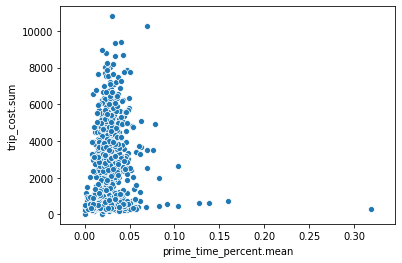

In [22]:
# Duration vs Price Model to figure out the outliers

sns.scatterplot(data=grouped_full, x="prime_time_percent.mean", y="trip_cost.sum")

In [23]:
average_rider_earnings = grouped_full["trip_cost.sum"].mean()

In [24]:
grouped_full["earnings_type"] = grouped_full["trip_cost.sum"].apply(lambda x: "more_than_average" if x > average_rider_earnings else "less_than_average")

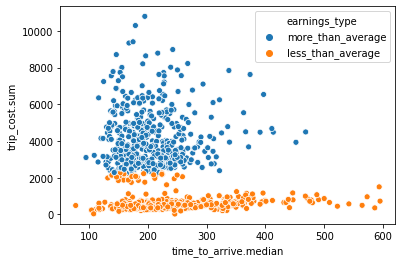

In [25]:
sns.scatterplot(data=grouped_full, y="trip_cost.sum", x="time_to_arrive.median", hue="earnings_type")

In [26]:
def timeOfDay(ts):
    hour = ts.hour
    if (hour >= 0) and (hour<5):
        return "ODD_TIME"
    if (hour >= 5) and (hour < 9):
        return "MORNING"
    if (hour >= 9) and (hour < 12):
        return "LATE_MORNING"
    if (hour >= 12) and (hour < 15):
        return "AFTERNOON"
    if (hour >= 15) and (hour < 18):
        return "EVENING"
    if (hour >= 18) and (hour < 21):
        return "NIGHT"
    if (hour >= 21) and (hour < 24):
        return "LATE_NIGHT"

#0 - 5 Odd time
# 5-9 Morning
# 9 -12
# 12 -3 # Afternoon
# 3 -6 Late afternoon
# 6 - 9 Night
# 9 - 12 Late Night

In [27]:
full_df["time_of_day"] = full_df.apply(lambda x: timeOfDay(x["picked_up_time"].tz_localize('US/Pacific')), axis=1)

In [28]:
full_df["month"] = full_df["picked_up_time"].apply(lambda x: x.month)
full_df["day"] = full_df["picked_up_time"].apply(lambda x: x.day)

In [29]:
def is_weekend_rush(ts, time_of_day):
    wkd = ts.weekday()
    hr = ts.hour
    if (wkd >= 5 ) or (wkd == 4 and time_of_day == "NIGHT") or (wkd == 4 and time_of_day == "LATE_NIGHT"):
        return True
    else:
        return False

In [30]:
full_df["is_weekend_rush"] = full_df.apply(lambda x: is_weekend_rush(x["picked_up_time"], x["time_of_day"]), axis=1)

In [31]:
full_df["day_name"] = full_df["picked_up_time"].apply(lambda x: x.day_name())

In [32]:
grouped_full = full_df.groupby("driver_id").agg({"mean", "median", "sum", "size"})
grouped_full.columns =grouped_full.columns.map('.'.join).str.strip('.')
grouped_full = grouped_full.reset_index(drop=False)

In [33]:
grouped_full["earnings_per_day"] = grouped_full["trip_cost.sum"]/grouped_full["time_at_lyft.mean"]

In [34]:
grouped_full["avg_rides_per_day"] = grouped_full["day.size"]/grouped_full["time_at_lyft.mean"]

In [35]:
def earningType(x, avgEarning):
    if x > (1.5 * avgEarning):
        return "OverAcheiver"
    elif x >= avgEarning:
        return "AboveAverage"
    elif x < (avgEarning - (0.5 * avgEarning)):
        return "UnderAcheiver"
    elif x < avgEarning:
        return "BelowAverage"

In [36]:
grouped_filtered = grouped_full[grouped_full["driver_id"].isin(no_ride_drivers) == False]

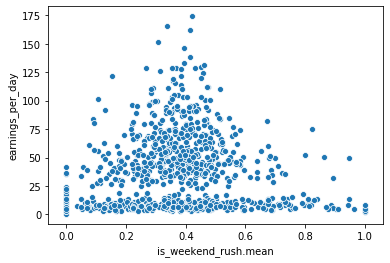

In [37]:
sns.scatterplot(data=grouped_filtered, x="is_weekend_rush.mean", y="earnings_per_day")

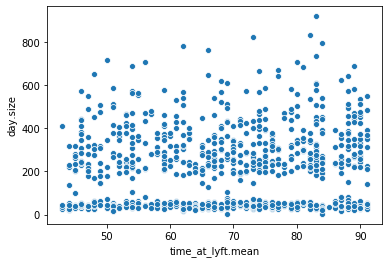

In [38]:
sns.scatterplot(data=grouped_filtered, x="time_at_lyft.mean", y="day.size")

In [39]:
median_earning = grouped_filtered["trip_cost.sum"].median()
avg_earning = grouped_filtered["trip_cost.sum"].mean()
grouped_filtered["median_cut_off_earning"] = grouped_filtered["trip_cost.sum"].apply(lambda x: earningType(x, median_earning))
grouped_filtered["mean_cut_off_earning"] = grouped_filtered["trip_cost.sum"].apply(lambda x: earningType(x, avg_earning))


/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [186]:
grouped_filtered.columns

Index(['driver_id', 'ride_distance.mean', 'ride_distance.median',
       'ride_distance.size', 'ride_distance.sum', 'ride_duration.mean',
       'ride_duration.median', 'ride_duration.size', 'ride_duration.sum',
       'ride_prime_time.mean', 'ride_prime_time.median',
       'ride_prime_time.size', 'ride_prime_time.sum', 'trip_cost.mean',
       'trip_cost.median', 'trip_cost.size', 'trip_cost.sum',
       'cumulative_ride_distance.mean', 'cumulative_ride_distance.median',
       'cumulative_ride_distance.size', 'cumulative_ride_distance.sum',
       'cumulative_ride_duration.mean', 'cumulative_ride_duration.median',
       'cumulative_ride_duration.size', 'cumulative_ride_duration.sum',
       'cumulative_ride_prime_time.mean', 'cumulative_ride_prime_time.median',
       'cumulative_ride_prime_time.size', 'cumulative_ride_prime_time.sum',
       'cumulative_trip_cost.mean', 'cumulative_trip_cost.median',
       'cumulative_trip_cost.size', 'cumulative_trip_cost.sum',
       'total_tri

In [185]:
grouped_filtered.groupby(['median_cut_off_earning']).agg({"mean", "sum","size", "median"})

ride_distance.mean                                  \
                                     mean       median size           sum   
median_cut_off_earning                                                      
AboveAverage                  6711.774452  6464.393701  187  1.255102e+06   
BelowAverage                  7201.046249  6170.930000   77  5.544806e+05   
OverAcheiver                  7185.143589  6676.148515  282  2.026210e+06   
UnderAcheiver                 7416.032699  6914.800000  391  2.899669e+06   

                       ride_distance.median                           \
                                       mean   median size        sum   
median_cut_off_earning                                                 
AboveAverage                    4034.994652  3978.00  187   754544.0   
BelowAverage                    4459.928571  3940.50   77   343414.5   
OverAcheiver                    4182.053191  3952.25  282  1179339.0   
UnderAcheiver                   4530.575448  4240.50  391  1771455.0   

                       ride_distance.size         ... maxStreak        \
                                     mean median  ...      size   sum   
median_cut_off_earning                            ...                   
AboveAverage                   243.566845  240.0  ...       187  1863   
BelowAverage                   149.857143  147.0  ...        77   311   
OverAcheiver                   420.606383  394.5  ...       282  4693   
UnderAcheiver                   45.537084   43.0  ...       391  1321   

                       totalDaysAppUsed                    active_percent  \
                                   mean median size    sum           mean   
median_cut_off_earning                                                      
AboveAverage                  38.117647     38  187   7128       0.576382   
BelowAverage                  16.961039     21   77   1306       0.402185   
OverAcheiver                  51.070922     50  282  14402       0.735019   
UnderAcheiver                  9.933504     10  391   3884       0.171733   

                                                   
                          median size         sum  
median_cut_off_earning                             
AboveAverage            0.573922  187  106.054347  
BelowAverage            0.441311   77   18.500528  
OverAcheiver            0.748333  282  207.275229  
UnderAcheiver           0.163908  391   58.732729  

[4 rows x 292 columns]

In [40]:
passive_riders = grouped_filtered[grouped_filtered["avg_rides_per_day"] < 2]["driver_id"]

In [41]:
passive_riders.shape

(350,)

In [42]:
active_riders = grouped_filtered[grouped_filtered.driver_id.isin(passive_riders) == False]

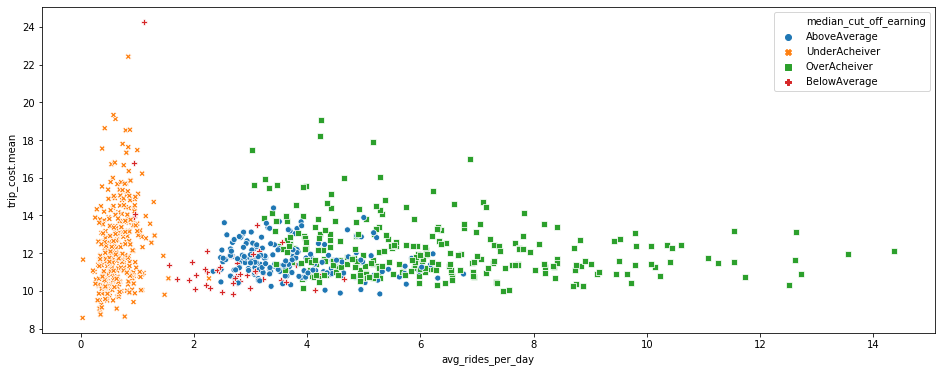

In [43]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=grouped_filtered, x="avg_rides_per_day", y="trip_cost.mean", style="median_cut_off_earning", hue="median_cut_off_earning")

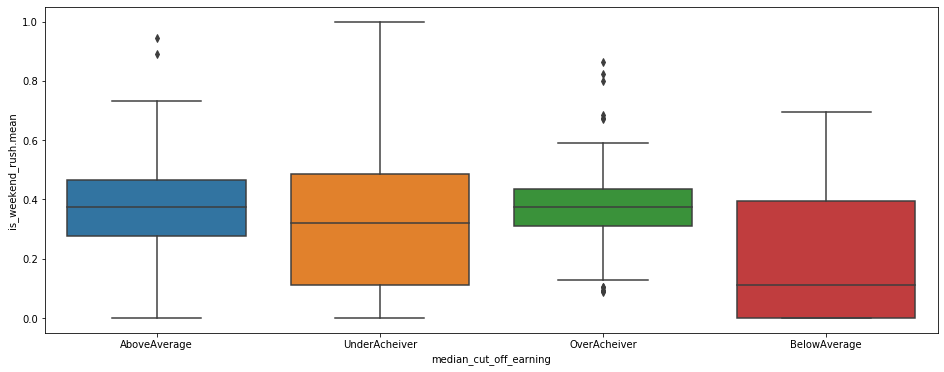

In [187]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="is_weekend_rush.mean")

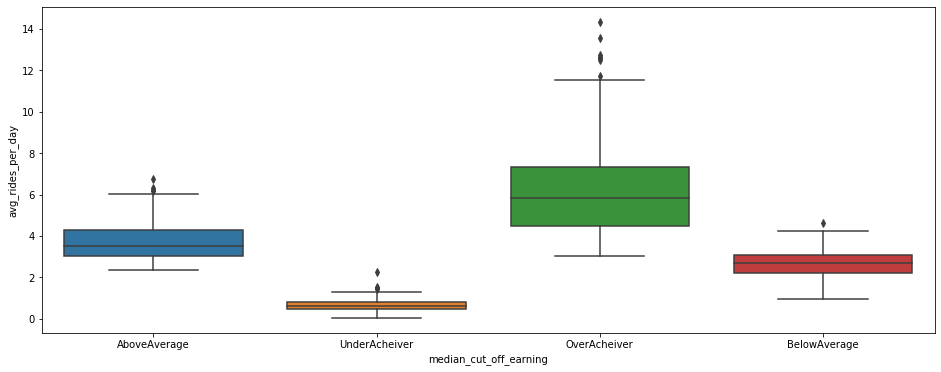

In [45]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="avg_rides_per_day")

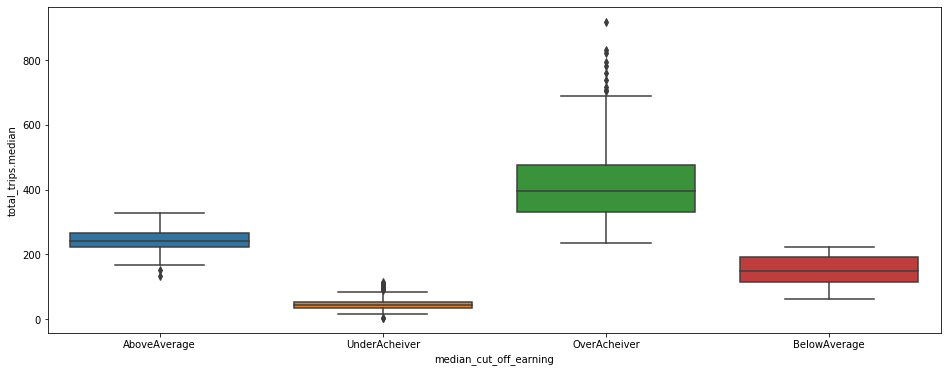

In [46]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="total_trips.median")

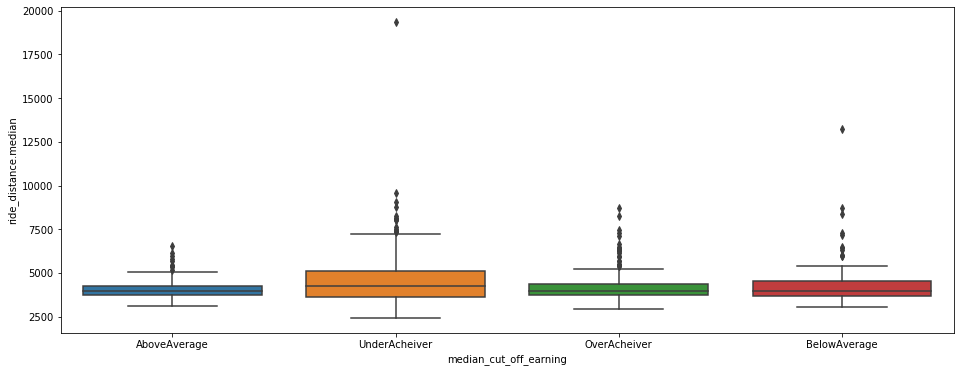

In [196]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_distance.median")

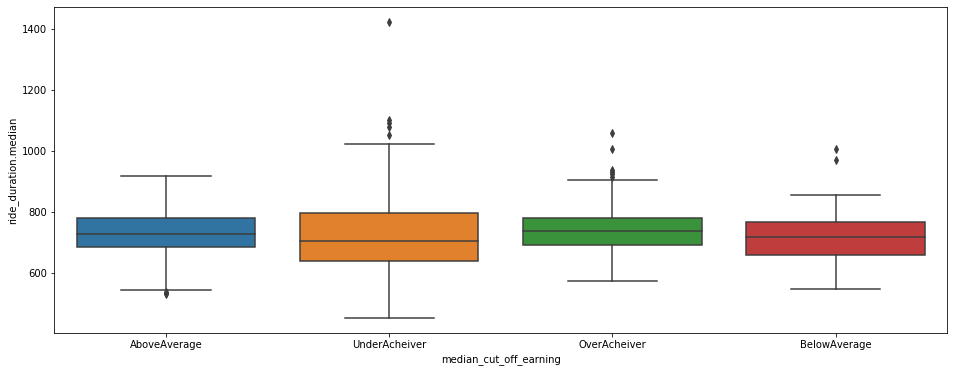

In [48]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_duration.median")

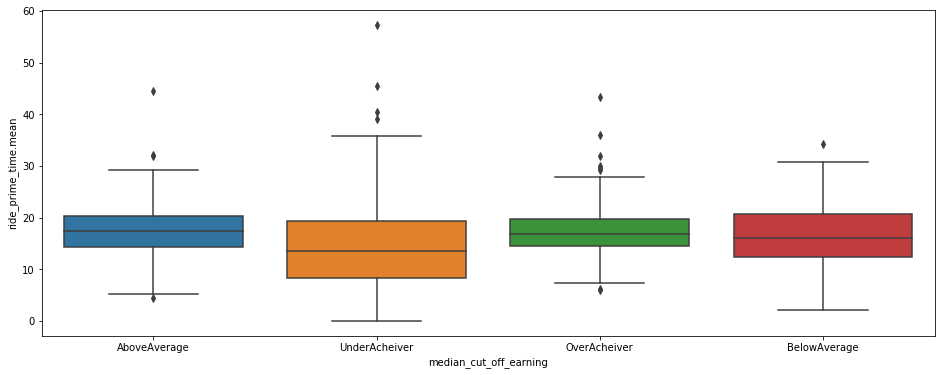

In [49]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_prime_time.mean")

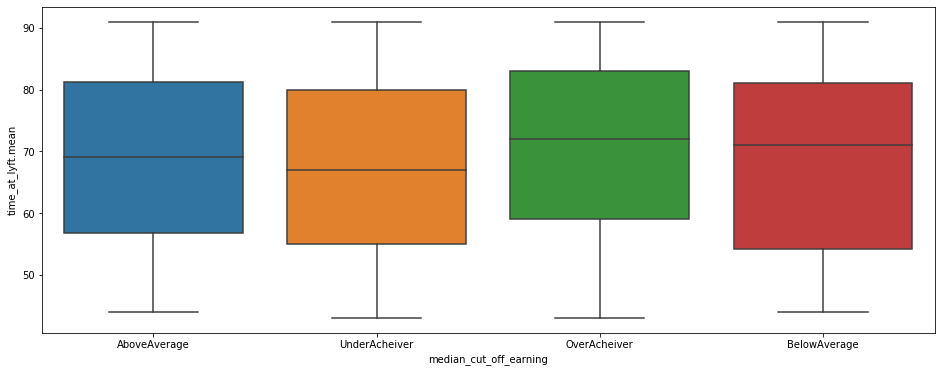

In [50]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="time_at_lyft.mean")

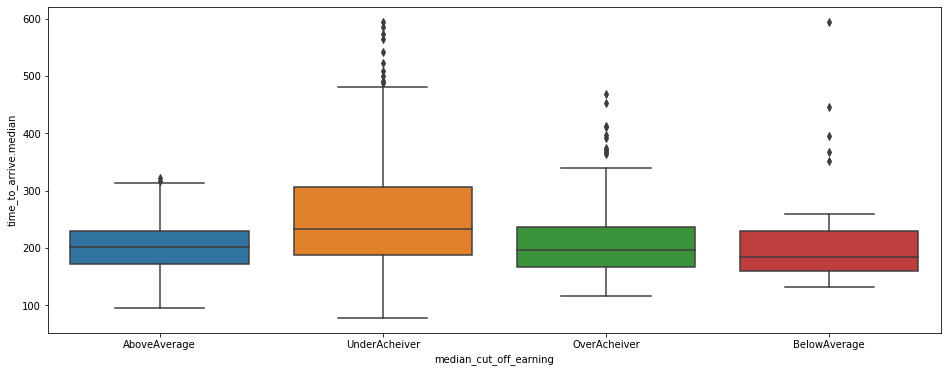

In [193]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="time_to_arrive.median")

In [52]:
time_grouped = full_df.groupby(['driver_id', 'day_name', 'time_of_day']).agg({"sum", "median", "mean", "size"})
time_grouped.columns =time_grouped.columns.map('.'.join).str.strip('.')
time_grouped = time_grouped.reset_index(drop=False)
time_grouped = time_grouped[time_grouped["driver_id"].isin(no_ride_drivers) == False]

In [53]:
merge_df = grouped_filtered[['driver_id', 'median_cut_off_earning']]
time_grouped_merged= time_grouped.merge(merge_df, on="driver_id")

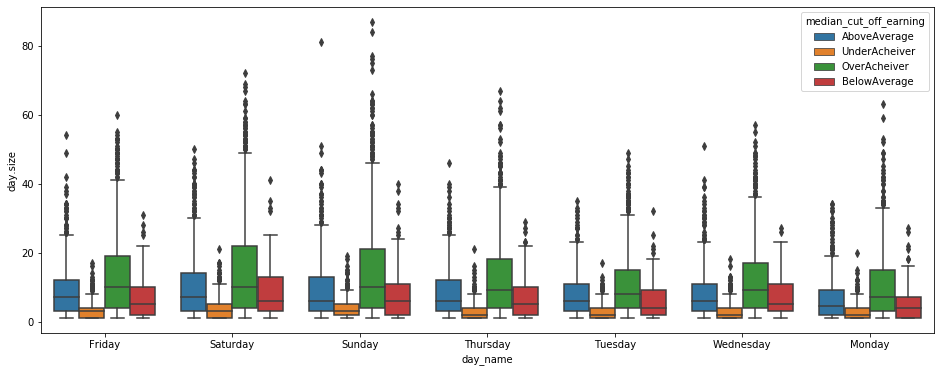

In [54]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=time_grouped_merged, x="day_name", y="day.size", hue="median_cut_off_earning")

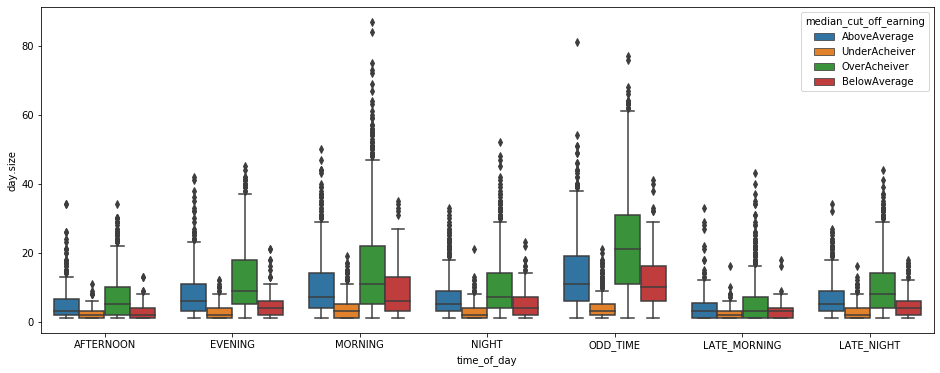

In [189]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=time_grouped_merged, x="time_of_day", y="day.size", hue="median_cut_off_earning")

In [55]:
top_5 = grouped_filtered.sort_values("trip_cost.sum", ascending=False)["driver_id"]

In [56]:
time_merged_top5 = time_grouped_merged[time_grouped_merged.driver_id.isin(top_5[0:5].values)]

In [57]:
time_merged_top5.shape

(198, 72)

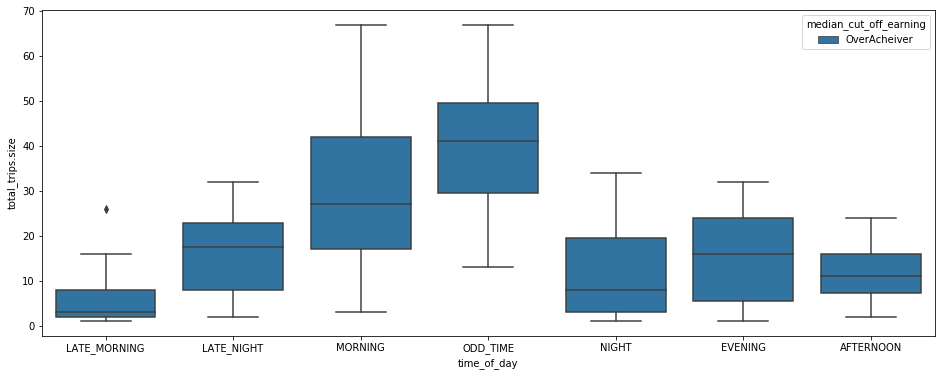

In [188]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=time_merged_top5, x="time_of_day", y="total_trips.size", hue="median_cut_off_earning")

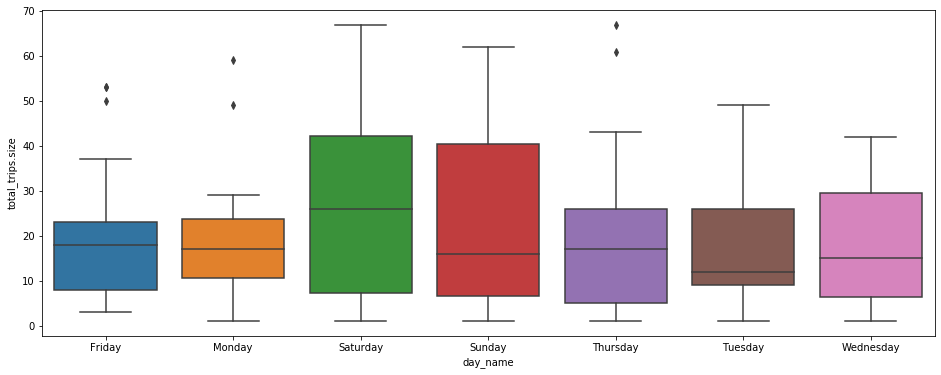

In [59]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=time_merged_top5, x="day_name", y="total_trips.size")

In [60]:
time_grouped_merged.columns

Index(['driver_id', 'day_name', 'time_of_day', 'ride_distance.mean',
       'ride_distance.median', 'ride_distance.size', 'ride_distance.sum',
       'ride_duration.mean', 'ride_duration.median', 'ride_duration.size',
       'ride_duration.sum', 'ride_prime_time.mean', 'ride_prime_time.median',
       'ride_prime_time.size', 'ride_prime_time.sum', 'trip_cost.mean',
       'trip_cost.median', 'trip_cost.size', 'trip_cost.sum',
       'cumulative_ride_distance.mean', 'cumulative_ride_distance.median',
       'cumulative_ride_distance.size', 'cumulative_ride_distance.sum',
       'cumulative_ride_duration.mean', 'cumulative_ride_duration.median',
       'cumulative_ride_duration.size', 'cumulative_ride_duration.sum',
       'cumulative_ride_prime_time.mean', 'cumulative_ride_prime_time.median',
       'cumulative_ride_prime_time.size', 'cumulative_ride_prime_time.sum',
       'cumulative_trip_cost.mean', 'cumulative_trip_cost.median',
       'cumulative_trip_cost.size', 'cumulative_trip_c

In [61]:
median_earning

2287.137490039199

In [62]:
avg_earning

2465.165132499584

In [63]:
grouped_filtered["median_cut_off_earning"].value_counts()

UnderAcheiver    391
OverAcheiver     282
AboveAverage     187
BelowAverage      77
Name: median_cut_off_earning, dtype: int64

In [64]:
underacheived = grouped_filtered[grouped_filtered["median_cut_off_earning"]=="UnderAcheiver"]

In [65]:
underacheived.shape

(391, 73)

In [66]:
below = grouped_filtered[grouped_filtered["trip_cost.sum"] < median_earning]
above = grouped_filtered[grouped_filtered["trip_cost.sum"] > median_earning]
overacheive_less_duration = above[(above["time_at_lyft.mean"] < 50) & (above["median_cut_off_earning"]=="OverAcheiver")]
below_average_more_duration = below[(below["time_at_lyft.mean"] >= 50) & (below["median_cut_off_earning"]=="BelowAverage")]

In [67]:
overacheive_less_duration.shape

(23, 73)

In [68]:
below_average_more_duration.shape

(37, 73)

In [69]:
combined = pd.concat([overacheive_less_duration,below_average_more_duration])
# Now remove off the passive riders
combined = combined[combined.driver_id.isin(passive_riders)==False]

In [70]:
combined["median_cut_off_earning"].value_counts()

BelowAverage    28
OverAcheiver    23
Name: median_cut_off_earning, dtype: int64

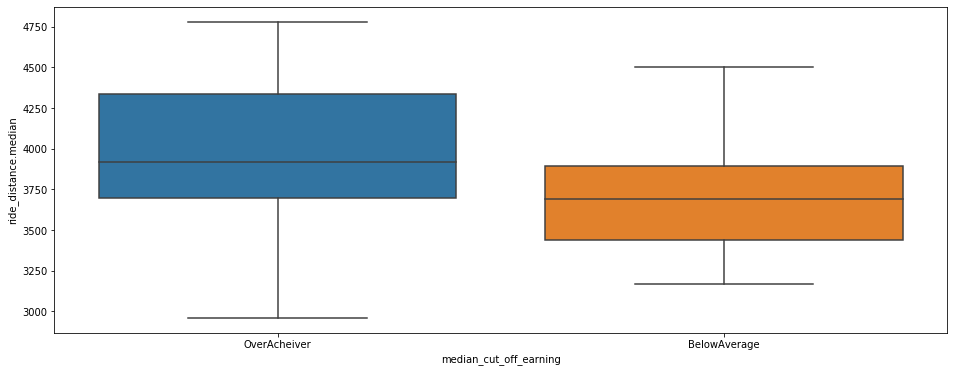

In [71]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=combined, x="median_cut_off_earning", y="ride_distance.median")

In [72]:
## Taking longer trips instead of shorter trips

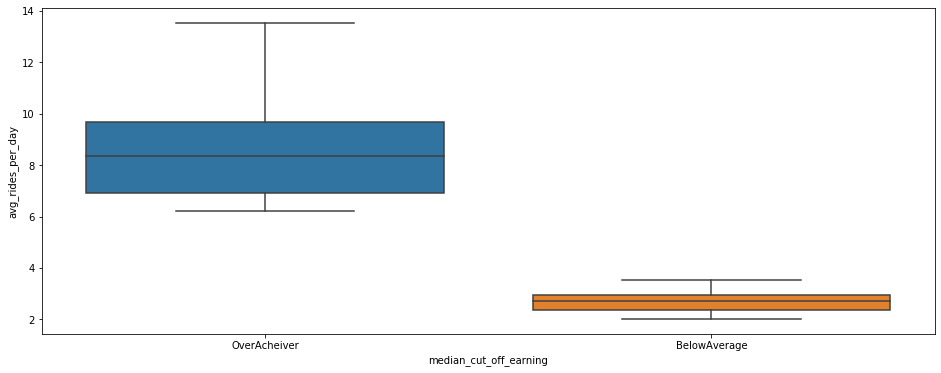

In [73]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=combined, x="median_cut_off_earning", y="avg_rides_per_day")

In [74]:
below.shape

(468, 73)

In [75]:
below.isna().apply(lambda x: sum(x))

driver_id                  0
ride_distance.mean         0
ride_distance.median       0
ride_distance.size         0
ride_distance.sum          0
                          ..
is_weekend_rush.sum        0
earnings_per_day          80
avg_rides_per_day         80
median_cut_off_earning     0
mean_cut_off_earning       0
Length: 73, dtype: int64

In [76]:
below["time_at_lyft.mean"]

1       90.0
2       83.0
7       51.0
10      55.0
11      88.0
        ... 
1008    63.0
1012    90.0
1013     NaN
1015     NaN
1017    80.0
Name: time_at_lyft.mean, Length: 468, dtype: float64

In [77]:
min(full_df["picked_up_time"])

Timestamp('2016-03-28 13:02:39')

In [78]:
max(full_df["picked_up_time"])

Timestamp('2016-06-27 07:02:06')

In [79]:
min(full_df["driver_onboard_date"])

Timestamp('2016-03-28 00:00:00-0700', tz='US/Pacific')

In [80]:
max(full_df["driver_onboard_date"])

Timestamp('2016-05-15 00:00:00-0700', tz='US/Pacific')

In [81]:
full_df.columns

Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time', 'trip_cost', 'cumulative_ride_distance',
       'cumulative_ride_duration', 'cumulative_ride_prime_time',
       'cumulative_trip_cost', 'total_trips', 'driver_onboard_date',
       'accepted_at_time', 'arrived_at_time', 'dropped_off_time',
       'picked_up_time', 'requested_at_time', 'time_to_accept',
       'time_to_arrive', 'time_for_customer_to_arrive', 'time_at_lyft',
       'prime_time_percent', 'time_of_day', 'month', 'day', 'is_weekend_rush',
       'day_name'],
      dtype='object')

### Initial Survival Analysis Projected lifetime

In [82]:
lifetimes_df = full_df[['driver_id', 'time_at_lyft', 'ride_distance', 'ride_duration', 'ride_prime_time', 'trip_cost']]

In [83]:
life_grouped = lifetimes_df.groupby('driver_id').agg({"sum", "mean", "median", "size"})
life_grouped.columns =life_grouped.columns.map('.'.join).str.strip('.')
life_grouped = life_grouped.reset_index(drop=False)

In [84]:
life_grouped_no_na = life_grouped.dropna(subset=['time_at_lyft.mean'])

### Our definition of death is riders with no ride in this 3 month interval 

In [85]:
#drivers_with_no_ride -> Failure
life_grouped_no_na["event_observed"] = life_grouped_no_na["driver_id"].apply(lambda x: True if x in no_ride_drivers else False)

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
life_grouped_no_na["avg_ride_per_day_in_tenure"] = life_grouped_no_na.apply(lambda x: 0 if x["driver_id"] in no_ride_drivers else (x["ride_distance.size"]/x["time_at_lyft.mean"]), axis=1)
life_grouped_no_na["avg_cost_per_ride_in_tenure"] = life_grouped_no_na.apply(lambda x: 0 if x["driver_id"] in no_ride_drivers else (x["trip_cost.sum"]/x["time_at_lyft.mean"]), axis=1)

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
lf_df = life_grouped_no_na[['driver_id', 'event_observed','time_at_lyft.mean', 'avg_ride_per_day_in_tenure', 'avg_cost_per_ride_in_tenure', 'trip_cost.sum', 'ride_distance.size']]

In [88]:
from lifelines import KaplanMeierFitter
T = lf_df["time_at_lyft.mean"]
event_observed = lf_df["event_observed"]
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed)

<lifelines.KaplanMeierFitter: fitted with 937 observations, 854 censored>

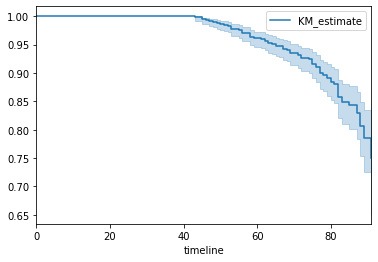

In [89]:
kmf.plot_survival_function()

### Higher number of suspensions, need to increase the "failed" cases through a different assumption

In [94]:
lf_df_cph = lf_df[['time_at_lyft.mean', 'event_observed','avg_ride_per_day_in_tenure', 'avg_cost_per_ride_in_tenure']]
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(lf_df_cph, duration_col="time_at_lyft.mean", event_col="event_observed")

/home/mancunian92/anaconda3/lib/python3.6/site-packages/lifelines/utils/__init__.py:1040: ConvergenceWarning: Column avg_cost_per_ride_in_tenure have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_observed'].astype(bool)
>>> print(df.loc[events, 'avg_cost_per_ride_in_tenure'].var())
>>> print(df.loc[~events, 'avg_cost_per_ride_in_tenure'].var())

A very low variance means that the column avg_cost_per_ride_in_tenure completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/mancunian92/anaconda3/lib/python3.6/site-packages/lifelines/fitters/coxph_fitter.py:570: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently in 50 steps.
  "Newton-Rhaphson failed to

<lifelines.CoxPHFitter: fitted with 937 observations, 854 censored>

In [95]:
lf_df_cph.isna().apply(lambda x: sum(x))

time_at_lyft.mean              0
event_observed                 0
avg_ride_per_day_in_tenure     0
avg_cost_per_ride_in_tenure    0
dtype: int64

In [96]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 937 observations, 854 censored>
      duration col = 'time_at_lyft.mean'
         event col = 'event_observed'
number of subjects = 937
  number of events = 83
partial log-likelihood = -291.03
  time fit was run = 2019-09-15 19:39:17 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
avg_ride_per_day_in_tenure  -16.60      0.00      9.95          -36.10            2.91                0.00               18.38
avg_cost_per_ride_in_tenure   0.36      1.43      0.81           -1.23            1.95                0.29                7.06

                                z    p  -log2(p)
avg_ride_per_day_in_tenure  -1.67 0.10      3.39
avg_cost_per_ride_in_tenure  0.44 0.66      0.60
---
Concordance = 0.96
Log-likelihood ratio test = 420.86 on 2 df, -log2(p)=303.58


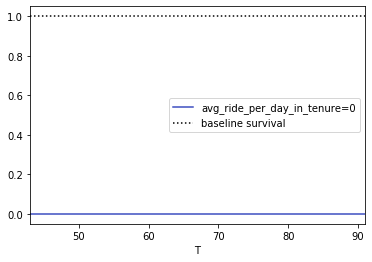

In [97]:
cph.plot_covariate_groups('avg_ride_per_day_in_tenure', range(0,1,3), cmap='coolwarm')

In [98]:
# We need another definition of failed drivers .. so that it includes more observation. 

In [99]:
full_df["day"].unique()

array([23., 30., 21., 19., 17.,  2., 25., 10., 13., 16., 20., 22.,  1.,
        9., 27.,  6.,  5.,  7., 15.,  3., 24., 12., 14., 18., 28., 26.,
       29.,  8., 31.,  4., 11., nan])

In [100]:
full_df["month"].unique()

array([ 4.,  3.,  6.,  5., nan])

In [101]:
sm_df = full_df.groupby(['driver_id', 'month', 'day']).size().reset_index().head(1)

In [102]:
min_date = min(full_df["requested_at_time"])

In [103]:
max_date = max(full_df["requested_at_time"])

In [104]:
sm_df[(sm_df.day ==min_date.day) & (sm_df.month == min_date.month)].shape[0]

0

In [105]:
def calculateMaxStreakAndTotalDaysUsed(driverId, df, min_date, max_date):
    # Returns a array if they ridden a ride in that day or not.
    currentStreak = 0
    maxStreak = 0
    totalDaysUsed = 0
    drv_df = full_df[full_df.driver_id==driverId]
    drv_df = drv_df.groupby(['month', 'day']).size().reset_index(drop=False)
    drv_df.columns = ['month', 'day', 'cnt']
    if drv_df.shape[0] == 0:
       return (0,0) 
    check_date = min_date
    while(check_date < max_date):
        if (drv_df[(drv_df.day ==check_date.day) & (drv_df.month == check_date.month)].shape[0]) > 0:
            # This has rows
            currentStreak+=1
            totalDaysUsed+=1
        else:
            if currentStreak > maxStreak:
                maxStreak=currentStreak                
            currentStreak=0
        check_date = check_date + timedelta(days=1)
    return maxStreak, totalDaysUsed
            

In [106]:
grouped_filtered["tuples"] = grouped_filtered["driver_id"].apply(lambda x: calculateMaxStreakAndTotalDaysUsed(x, full_df, min_date, max_date))

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
grouped_filtered["maxStreak"] = grouped_filtered["tuples"].apply(lambda x: x[0])
grouped_filtered["totalDaysAppUsed"] = grouped_filtered["tuples"].apply(lambda x: x[1])

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
grouped_filtered.columns

Index(['driver_id', 'ride_distance.mean', 'ride_distance.median',
       'ride_distance.size', 'ride_distance.sum', 'ride_duration.mean',
       'ride_duration.median', 'ride_duration.size', 'ride_duration.sum',
       'ride_prime_time.mean', 'ride_prime_time.median',
       'ride_prime_time.size', 'ride_prime_time.sum', 'trip_cost.mean',
       'trip_cost.median', 'trip_cost.size', 'trip_cost.sum',
       'cumulative_ride_distance.mean', 'cumulative_ride_distance.median',
       'cumulative_ride_distance.size', 'cumulative_ride_distance.sum',
       'cumulative_ride_duration.mean', 'cumulative_ride_duration.median',
       'cumulative_ride_duration.size', 'cumulative_ride_duration.sum',
       'cumulative_ride_prime_time.mean', 'cumulative_ride_prime_time.median',
       'cumulative_ride_prime_time.size', 'cumulative_ride_prime_time.sum',
       'cumulative_trip_cost.mean', 'cumulative_trip_cost.median',
       'cumulative_trip_cost.size', 'cumulative_trip_cost.sum',
       'total_tri

In [109]:
cols_to_merge = grouped_filtered[['driver_id', 'maxStreak', 'totalDaysAppUsed']]
time_grouped_merged = time_grouped_merged.merge(cols_to_merge, on="driver_id")

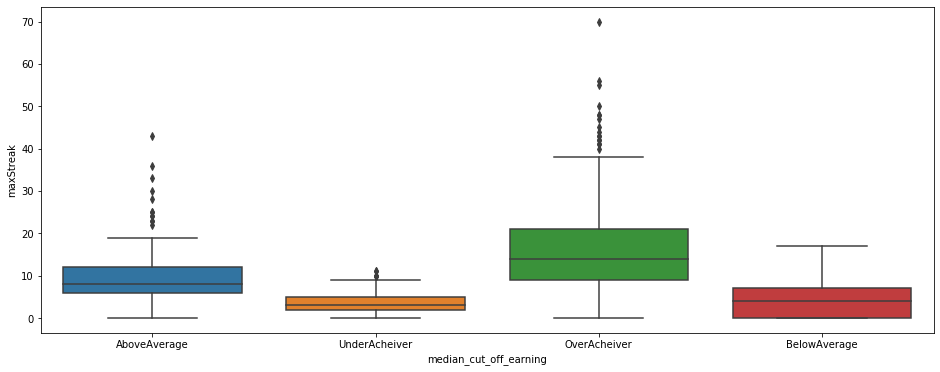

In [110]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="maxStreak")

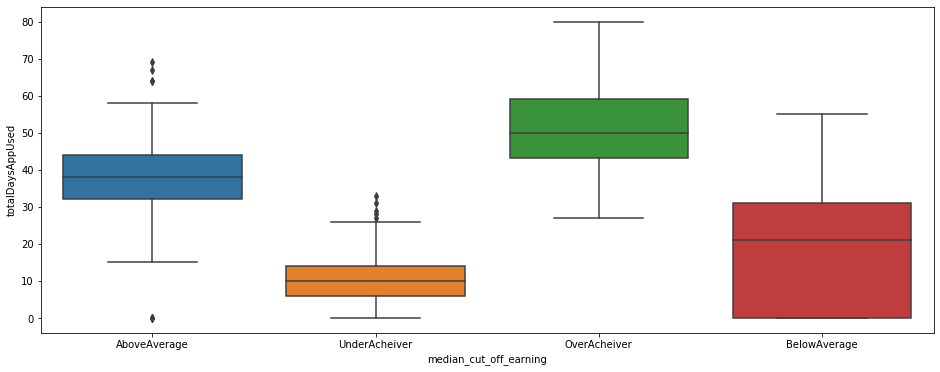

In [111]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="totalDaysAppUsed")

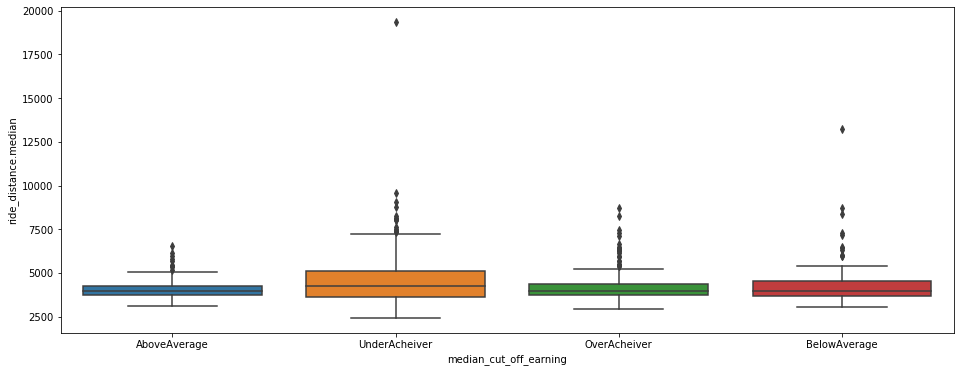

In [194]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=grouped_filtered, x="median_cut_off_earning", y="ride_distance.median")

### There is a clear distinction in rewards (money made in app) to total days

In [112]:
grouped_filtered["active_percent"] = (grouped_filtered["totalDaysAppUsed"]/grouped_filtered["time_at_lyft.mean"])

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
lf_df_iter_1 = grouped_filtered[["driver_id", "ride_distance.sum", "ride_duration.sum", "ride_prime_time.mean", "is_weekend_rush.mean", "time_to_arrive.median", "earnings_per_day", 'avg_rides_per_day','maxStreak', 'active_percent', "time_at_lyft.mean"]]
lf_df_iter_1["event_observed"] = lf_df_iter_1.apply(lambda x: True if ((x["active_percent"] <= 0.2) & (x["time_at_lyft.mean"] > 45)) else False, axis=1)

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [114]:
# We want to add the drivers with no ride here as well . Filling in the rest of the details as 0/ underacheiver and making them as failed cases
failed_cases_no_rides = grouped_full[grouped_full["driver_id"].isin(no_ride_drivers)][["driver_id", "time_at_lyft.mean"]]

In [115]:
# Filling in the defaults for 
failed_cases_no_rides['ride_distance.sum'] = 0
failed_cases_no_rides['ride_duration.sum'] = 0
failed_cases_no_rides['ride_prime_time.mean']=0
failed_cases_no_rides['is_weekend_rush.mean']=0
failed_cases_no_rides['time_to_arrive.median']=0
failed_cases_no_rides['earnings_per_day']=0
failed_cases_no_rides['avg_rides_per_day']=0
failed_cases_no_rides['maxStreak']=0
failed_cases_no_rides['active_percent']=0
failed_cases_no_rides['event_observed']=True

In [116]:
lf_df_1_merged = pd.concat([lf_df_iter_1, failed_cases_no_rides])

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [160]:
test_set = lf_df_1_merged[lf_df_1_merged["time_at_lyft.mean"].isna()]

In [161]:
train_set = lf_df_1_merged.dropna(subset=["time_at_lyft.mean"])

In [162]:
train_set["time_to_arrive.median"] = train_set["time_to_arrive.median"].fillna(0)

/home/mancunian92/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [163]:
wbf = WeibullFitter().fit(train_set["time_at_lyft.mean"], train_set["event_observed"])

In [164]:
wbf.median_

84.39269120112603

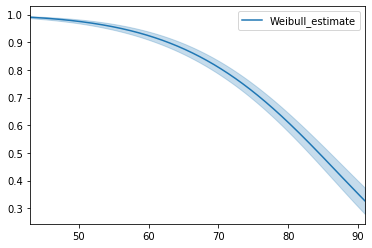

In [202]:
wbf.plot_survival_function()

In [201]:
np.nanmedian(grouped_filtered["time_at_lyft.median"])

69.0

In [165]:
# On an average each driver, (unconditional survival) will last 85 days. (By this dataset). As more information comes in these numbers will change

In [174]:
grouped_filtered.columns

Index(['driver_id', 'ride_distance.mean', 'ride_distance.median',
       'ride_distance.size', 'ride_distance.sum', 'ride_duration.mean',
       'ride_duration.median', 'ride_duration.size', 'ride_duration.sum',
       'ride_prime_time.mean', 'ride_prime_time.median',
       'ride_prime_time.size', 'ride_prime_time.sum', 'trip_cost.mean',
       'trip_cost.median', 'trip_cost.size', 'trip_cost.sum',
       'cumulative_ride_distance.mean', 'cumulative_ride_distance.median',
       'cumulative_ride_distance.size', 'cumulative_ride_distance.sum',
       'cumulative_ride_duration.mean', 'cumulative_ride_duration.median',
       'cumulative_ride_duration.size', 'cumulative_ride_duration.sum',
       'cumulative_ride_prime_time.mean', 'cumulative_ride_prime_time.median',
       'cumulative_ride_prime_time.size', 'cumulative_ride_prime_time.sum',
       'cumulative_trip_cost.mean', 'cumulative_trip_cost.median',
       'cumulative_trip_cost.size', 'cumulative_trip_cost.sum',
       'total_tri

### Lifetime value of a customer

In [176]:
avg_earnings_per_day = np.mean(grouped_filtered["earnings_per_day"])

In [177]:
avg_rides = np.mean(grouped_filtered["avg_rides_per_day"])

In [178]:
avg_value = avg_earnings_per_day * avg_rides

In [179]:
avg_value

126.0022702453533

In [180]:
avg_app_used = np.mean(grouped_filtered["totalDaysAppUsed"])

In [182]:
# Over a 90 Day span

In [181]:
avg_value * avg_app_used

3593.149051180192

In [190]:
avg_earnings_per_day

38.77044830438618

In [191]:
avg_rides

3.2499564940831083

In [192]:
avg_app_used

28.516542155816435